<a href="https://colab.research.google.com/github/Nick7900/glhmm_protocols/blob/main/Procedures/Procedure_4_Across_visits_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procedure 4: Across-state-visits Testing with [glhmm toolbox](https://github.com/vidaurre/glhmm)

In this tutorial, we demonstrate how to perform **across-state-visits testing** using the [GLHMM toolbox](https://github.com/vidaurre/glhmm). Details about the HMM and the different models can be found in the paper [The Gaussian-Linear Hidden Markov Model: a Python Package](https://direct.mit.edu/imag/article/doi/10.1162/imag_a_00460/127499/The-Gaussian-Linear-Hidden-Markov-model-a-Python). This test is designed to examine how **brain states** identified from brain activity relate to other signals measured at the same time, and that were not used for the estimation of the HMM (e.g. a physiological signal).   

For this example, we analyse the relationship between **brain activity** and **pupil size** during resting-state recordings. The data was collected from **10 participants** who underwent **Magnetoencephalography (MEG)** scans while resting in a dark room. Each participant completed **two sessions**, except for one participant with only one session. During these recordings:  
- **Brain activity** was measured, focusing on the **Default Mode Network (DMN)**.  
- **Pupillometry** was simultaneously recorded.

---

### Objective of this Procedure  

The key question is:  
**"Do changes in brain states, identified from MEG data, relate to changes in pupillometry during rest?"**  

To address this, we will:  
* Estimate brain states using a pre-trained Time-Delayed Embedding Hidden Markov Model (TDE-HMM) model ([Vidaurre et al., 2018](https://www.nature.com/articles/s41467-018-05316-z)), which can detect spectral changes without the need to predefine a frequency band. This produces a **Viterbi path** showing the sequence of brain states over time for each session (unlike the *Gamma* used in the other procedures, the Viterbi path is not a probability, but a categorical assigment). 
* Test the relationship between the state time courses (the Viterbi Path; the $D$ matrix) and pupil size (the $R$ matrix) using permutation testing.

---

### Structure of the Procedure
The steps in this tutorial follow the workflow shown in the figure below:

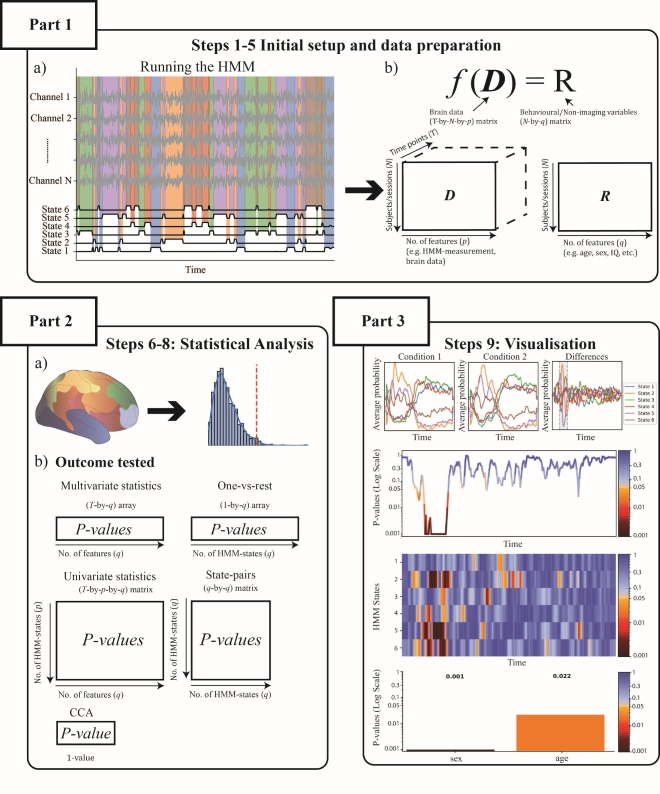

### Table of Contents
* [Part 1. Load and prepare data](#load-data)
    * [Step 1. Load data into Python environment](#prep_env)
    * [Step 2. Data structuring for the HMM](#data_shape)
    * [Step 3. Preprocessing data](#preprocess_data)
    * [Step 4. Set-up and train Hidden Markov Model](#data_handle1)
    * [Step 5. Configure HMM outputs for statistical analysis](#data_handle)
* [Part 2 & 3. Statistical Analysis and Visualisation](#stat_analysis)
    * [Step 6. Types of test - Across-state-visits test](#stat_test)
    * [Step 7. Multivariate test](#multi_test)
        * [Step 8. Multiple comparison test - Multivariate](#multi_corr)
        * [Step 9. P-value plots - Multivariate](#multi_vis)
    * [Step 7. Univariate test](#uni_test)
        * [Step 8. Multiple comparison test - Univariate](#uni_corr)
        * [Step 9. P-value plots - Univariate](#uni_corr2)
    * [Step 7. One-state-vs-the-rest (OSR) test](#rest_test)
        * [Step 8. Multiple comparison test - OSR](#one_rest_corr)
        * [Step 9. P-value plots - OSR](#one_rest_vis)
    * [Step 7. One-state-vs-another-state (OSA)](#pair_test)
        * [Step 8. Multiple comparison test - OSA](#pair_corr)
        * [Step 9. P-value plots - OSA](#pair_vis)
<a id="vis"></a>

### Install necessary packages
If you dont have the **GLHMM-package** installed or using **Google Colab**, then run the following command in your terminal:

```pip install git+https://github.com/vidaurre/glhmm```

### Import libraries
Let's start by importing the required libraries and modules.

In [2]:
# Install the GLHMM_package when using Google Colab
try:
    import google.colab
    IN_COLAB = True
    !pip install git+https://github.com/vidaurre/glhmm
except ImportError:
    IN_COLAB = False

# Import libraries
import numpy as np
from glhmm import graphics, statistics, preproc, io, utils
from pathlib import Path
import pickle
import scipy

## Part 1. Initial setup and data preparation <a id="load-data"></a>
### Step 1. Load data into Python environment <a id="prep_env"></a>

In [4]:
# Set up paths
PATH_WORKING = Path.cwd()
PATH_DATA = PATH_WORKING / "data" / "Procedure_4_data"
PATH_FIGURES = PATH_DATA / "figures"

# If the required data for the protocol paper is missing, this function downloads it from Zenodo.
io.prepare_data_directory(PATH_DATA)

# Load brain activity data
with open(PATH_DATA / "data_meg.pkl", "rb") as f:
    data_meg = pickle.load(f)

# Load behavioural data
with open(PATH_DATA / "pupillometry.pkl", "rb") as f:
    data_pupillometry = pickle.load(f)

# Load pre-traind TDE-HMM
hmm_TDE = io.read_flattened_hmm_mat(PATH_DATA / "hmm.mat")

# Load the settings of the TDE-HMM
hmm_TDE_settings = scipy.io.loadmat(PATH_DATA / 'hmm.mat')

# Display data information
print(f"Number of sessions in data_meg: {len(data_meg)}")
print(f"Number of sessions in data_pupillometry: {len(data_pupillometry)}")

Number of sessions in data_meg: 19
Number of sessions in data_pupillometry: 19


#### Explore the Dataset
Both the brain activity data and the pupillometry data are stored as lists, where each element corresponds to a recording session.

**Brain Data (`data_meg`)**\
The brain data contains 19 sessions of continuous recordings from the MEG. Each session is stored as a 2D matrix with the shape of `(No. of timepoints, No. of channels)`:
- Timepoints: The total number of recorded time points in the session.  
- Channels: Here regions according to a prespecified parcellation (see ([here](https://www.nature.com/articles/s41467-018-05316-z)) for details).  

**Pupillometry data (`data_pupillometry`)**
The pupillometry data was concurrently acquired and therefore also consists of 19 sessions. Each session is stored as a 1D array with the shape of `(No. of timepoints,)`.
* The length of each array matches the number of time points in the corresponding brain activity data (`data_meg`).
* Each value represents the pupil size measurement recorded continuously during the session.



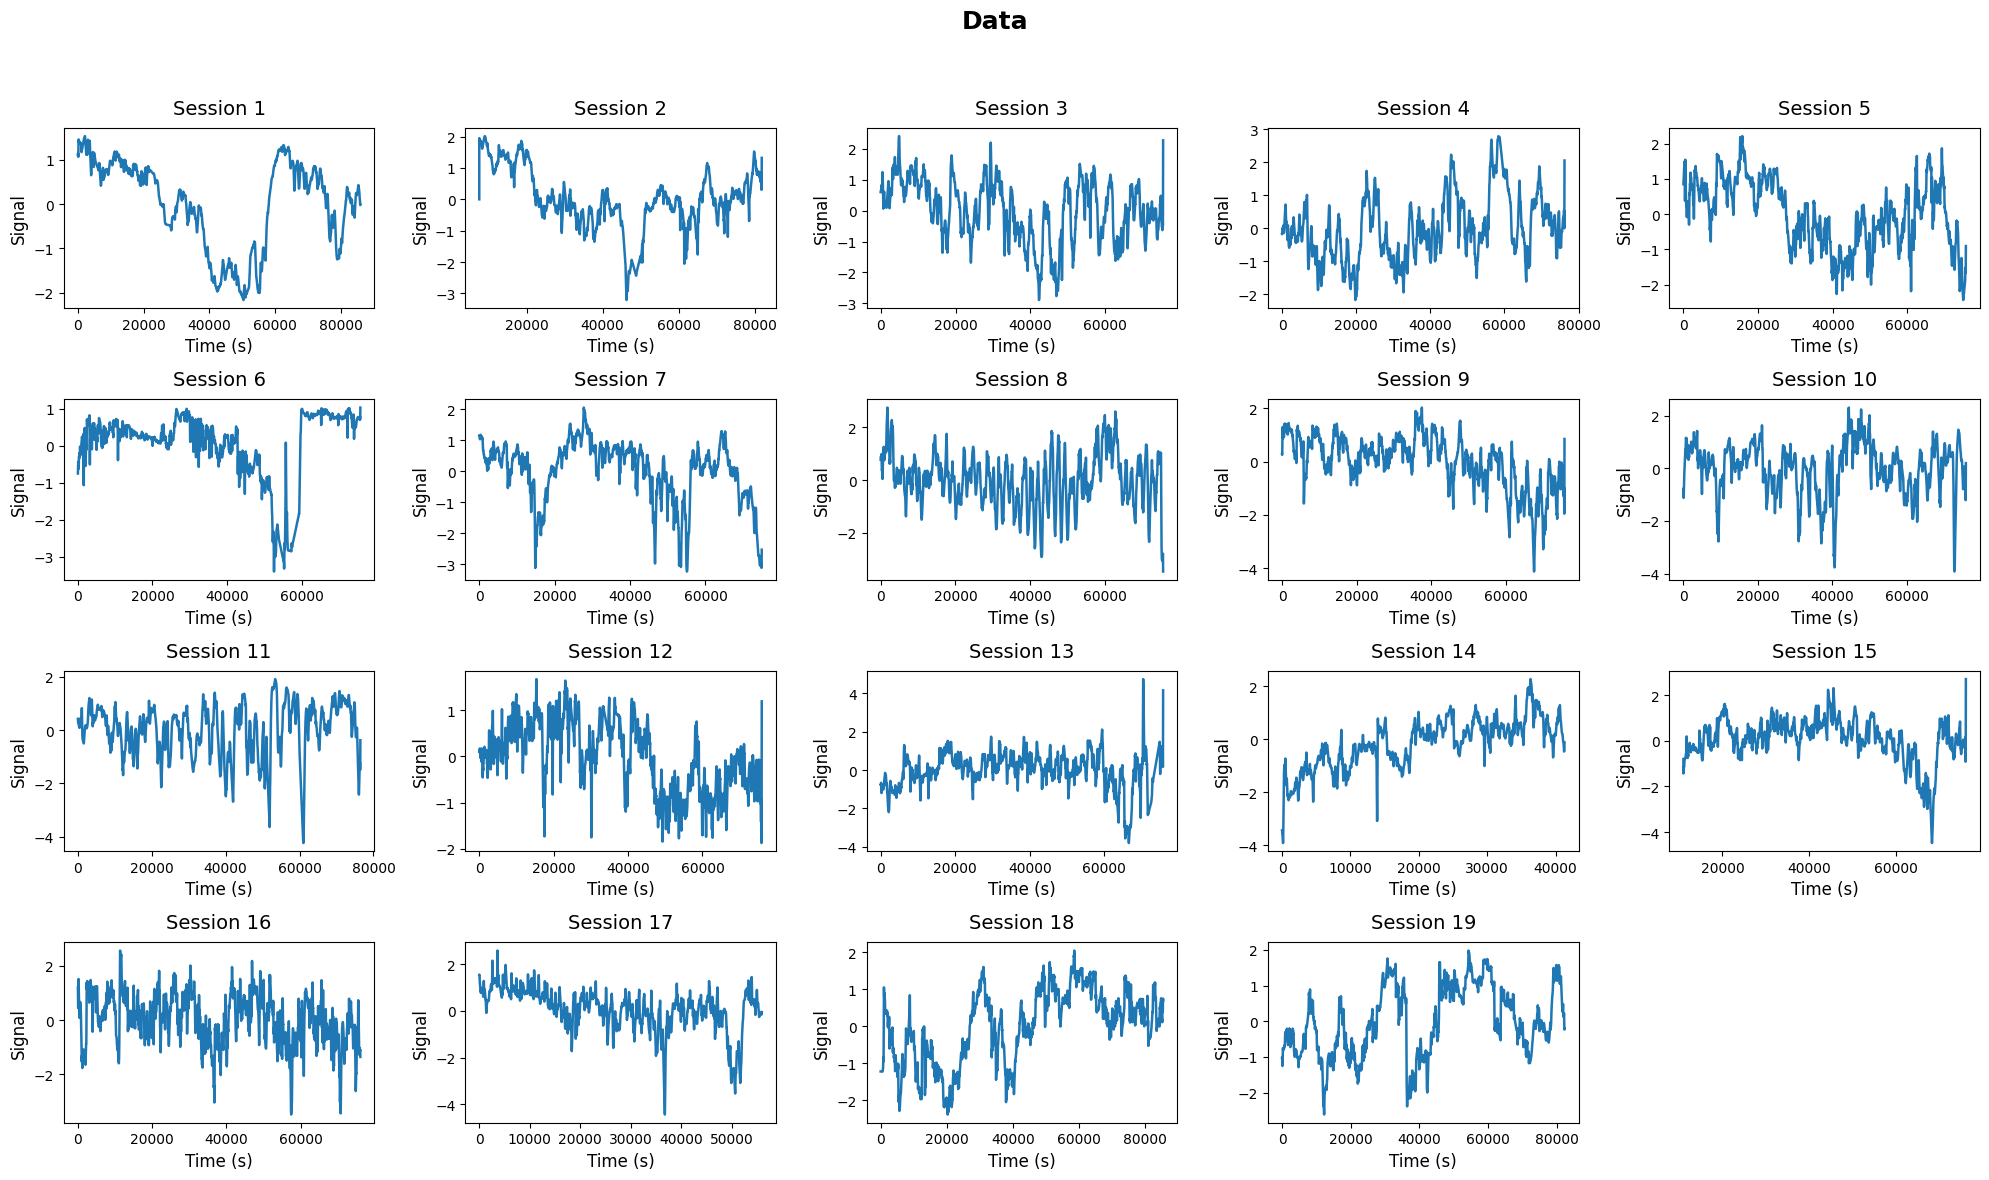

In [5]:
#Plot the pupillometry measurement
graphics.plot_data_grid(data_pupillometry, titles="Session")

### Step 2. Data structuring for the HMM <a id="data_shape"></a>
Before using the pre-trained TDE-HMM model to analyse the data, we need to organise both the brain activity (`data_meg`) and pupil size recordings (`data_pupillometry`) into the correct format. These datasets will be referred to as `D_con` and `R_data`, respectively. When performing the statistical tests, we examine the relationship between matrix $D$ (brain data) and matrix $R$ (pupil size data).

* **Concatenate brain activity (`D_con`)**\
The brain activity data (`data_meg`) contains recordings from multiple sessions. We concatenate all the sessions along the time dimension to form a single, continuous 2D matrix: `[timepoints × sessions, features]`.

* **Concatenate pupil size data (`R_data`)**\
Similarly, we concatenate all the pupil size recordings (`data_pupillometry`) along the time dimension to form a single 1D array: `[No of timepoints timepoints * No. of sessions,]`.

* **Create index matrix (`idx_data`)**\
To track the start and end timepoints for each session, we generate an index matrix, `idx_data`, using the function `get_indices_from_list`. It will have a shape of: `[No. of sessions, 2]`.
Each row specifies the start and end timepoints for a session. 

In [7]:
# Concatenate all MEG sessions into a single dataset
D_con = np.concatenate(data_meg, axis=0) if IN_COLAB==False else statistics.get_concatenate_data_memmap(data_meg)

# Concatenate all pupil size sessions into a single dataset
R_data = np.concatenate(data_pupillometry, axis=0)

# Get the start and end indices for each session
idx_data = statistics.get_indices_from_list(data_meg)
del data_meg, data_pupillometry# delete the raw file to save memory

# Display the shapes of the resulting structures
print(f"Shape of concatenated brain data (D_con): {D_con.shape}")
print(f"Shape of concatenated pupil size data (R_data): {R_data.shape}")
print(f"Shape of index matrix (idx_data): {idx_data.shape}")
print(f"Indices for each session:\n {idx_data}")

Shape of concatenated brain data (D_con): (1473460, 42)
Shape of concatenated pupil size data (R_data): (1473460,)
Shape of index matrix (idx_data): (19, 2)
Indices for each session:
 [[      0   85996]
 [  85996  167903]
 [ 167903  243307]
 [ 243307  319513]
 [ 319513  395198]
 [ 395198  470960]
 [ 470960  545894]
 [ 545894  621406]
 [ 621406  697049]
 [ 697049  772958]
 [ 772958  849412]
 [ 849412  925357]
 [ 925357 1001103]
 [1001103 1077394]
 [1077394 1153600]
 [1153600 1229804]
 [1229804 1305766]
 [1305766 1391210]
 [1391210 1473460]]


**Reviewing the data structure**

After structuring the data, we can the shapes of `D_con` and `idx_data`:

- `D_con`: The concatenated brain data has the shape `(1473460, 42)`, corresponding to the total number of timepoints across all sessions and the 42 brain regions (parcellations).
- `R_data`: The concatenated pupillometry data has the shape `(1473460,)`, corresponding to the total number of timepoints across all sessions.
- `idx_data`: The index matrix aligns with the 19 sessions and indicates the start and end timepoints for each session in `D_con`. For example, the first row might show `[0, 85996]`, representing the time range for the first session.

### Step 3. Preprocessing data <a id="preprocess_data"></a>
Before we can analyse the data using the TDE-HMM model, we need to preprocess the MEG recordings to ensure they are in the right format. However, **preprocessing and decoding the signal using the TDE-HMM are optional**. If you want to skip this step, you can use the pre-saved results provided for this tutorial in **Step 4**. These include:

* `Gamma`: The brain state probabilities.
* `vpath`: The sequence of brain states (Viterbi path).

For those who want to decode the signal using the pretrained TDE-HMM themselves, the preprocessing steps are as follows:

---
#### Preprocessing Steps:
To prepare the MEG data for analysis, we apply two key steps:

**1. Standardising the brain data**\
Standardisation ensures that all the time series data are on the same scale. We use the function `preprocess_data` to achieve this.

**2. Preparing Data for the TDE-HMM**\
To prepare the data, we use the `build_data_tde` function. This step adds time lags to capture changes in brain activity over short windows and applies a PCA projection.

* *Time Lags*: Capture how brain activity changes over a sliding window. Here, we use 7 time lags before and after each time point. This is called the embedding space. 
* *PCA*: Reduces the complexity of the embedding space. The PCA settings are loaded from `hmm_TDE_settings`.

**Note:** Preprocessing:
* ⚠️ **Cannot** preprocess or train the HMM on Google Colab due to memory constraints (Colab provides ~12GB in the free tier).  
* ➡️ Skip this step and go to **Step 4** to load pre-trained Gamma and Viterbi path values instead.

In [8]:
# Preprocess the data (standardise the time series)
D_preproc, idx_data_preproc = preproc.preprocess_data(
    data=D_con,
    indices=idx_data,
    standardise=True,  # Standardise the data
)
del D_con
# Load PCA projection settings
pca_proj = hmm_TDE_settings["train"]["A"][0][0]

# Specify time lags
embedded_lags = 7
lags = np.arange(-embedded_lags, embedded_lags + 1)

# Build the MEG data in TDE format
D_tde, indices_tde = preproc.build_data_tde(
    D_preproc,
    idx_data_preproc,
    lags=lags,
    pca=pca_proj
)

### Step 4. Set-up and train a HMM <a id="data_handle1"></a>
The TDE-HMM identifies patterns in brain activity over time. It identifies states in the data, which in this case represent recurrent periods with meta-stable spectral properties. 

For the sake of this tutorial, the two main outputs of the HMM are:

* `Gamma_tde`: the probability of being in each state at every timepoint.
* Viterbi Path (`D_vpath_tde`): the most likely sequence of states over time, which is categorical instead of probabilistic. 

In this protocol, unlike previous protocols, we focus on the Viterbi Path ($D$ matrix) for understanding state transitions and their relationship to changes in pupil size.

---

**Option 1: Skip Training with pre-saved `Gamma_tde` and Viterbi Path values**

If you prefer to skip the HMM training, pre-saved `Gamma_tde`, `D_vpath_tde` and `indices_tde` data are provided. This allows you to proceed directly to the statistical testing phase without running any training steps.

To load the pre-saved results, use the following code in a new cell:

```python
# Load pre-saved HMM results
Gamma_tde = np.load(PATH_DATA / "Gamma_tde.npy")
D_vpath_tde = np.load(PATH_DATA / "D_vpath_tde.npy")
indices_tde = np.load(PATH_DATA / "indices_tde.npy")

```
---

**Option 2: Decode data using the pre-trained TDE-HMM**\
If you have preprocessed the data and want to decode the HMM yourself, use the following code to decode the state time courses (`Gamma_tde`) and Viterbi Path (`D_vpath_tde`).


In [7]:
# Decode Gamma (state probabilities)
Gamma_tde, _, _ = hmm_TDE.decode(X=None, Y=D_tde, indices=indices_tde)
# Decode Viterbi Path (most likely sequence of states)
D_vpath_tde = hmm_TDE.decode(X=None, Y=D_tde, indices=indices_tde, viterbi=True)

/home/nick/.conda/envs/GLHMM_env/lib/python3.9/site-packages/glhmm/auxiliary.py:241: RuntimeWarning: invalid value encountered in divide
  a[t,:,:] = a[t,:,:] / xp.expand_dims(sc[t,:],axis=1)
/home/nick/.conda/envs/GLHMM_env/lib/python3.9/site-packages/glhmm/auxiliary.py:352: RuntimeWarning: invalid value encountered in divide
  delta[t,:,:] = delta[t,:,:] / np.expand_dims(np.sum(delta[t,:,:],axis=1),axis=1)


### 5. Configure HMM outputs for statistical analysis <a id="data_handle"></a>
Remember we want to identify associations between the Viterbi path (brain states, $D$) and the simultaneously recorded pupillometry data ($R$). Now, let us examine the dimensions of the pupillometry data and the Viterbi path for the first session. Specifically, we need to be sure that both datasets are aligned before we can do the statistical tests.

Before aligning the data, let’s inspect their dimensions:

In [11]:
# Display dimensions of the data
print(f"Dimension of Viterbi path (D-matrix): {D_vpath_tde.shape}")
print(f"Dimension of pupillometry (R-matrix): {R_data.shape}")

Dimension of Viterbi path (D-matrix): (1473194, 12)
Dimension of pupillometry (R-matrix): (1473460,)



We notice a difference in the lengths between ```D_vpath_tde``` (1473194, 12) and ```R_data``` (1473460,). This difference happens because the TDE-HMM introduces a lag of 7 timepoints (`embedded_lags`) at both the start and end of each session, which removes 14 timepoints per session.

**Aligning the data**

To align the dimensions, we need to pad the Viterbi path (`D_vpath_tde`) by adding 7 timepoints at the start and end of each session. 

This adjusts the Viterbi path to match the original length of the pupillometry data (R_data), and make them compatible for analysis. We use the  `pad_vpath` function for this step:
* `D_vpath_tde`: The Viterbi path to be padded.
* `embedded_lags`: The number of lagged timepoints (7 in this case).
* `indices_tde`: Marks the start and end boundaries of each session

In [14]:
# Lag steps
embedded_lags = 7
# Pad the Viterbi path
D_vpath_pad = statistics.pad_vpath(D_vpath_tde, embedded_lags, indices_tde)
del D_vpath_tde

# Verify dimensions after padding
print(f"Dimension of Viterbi path after padding (D-matrix): {D_vpath_pad.shape}")
print(f"Dimension of pupillometry (R-matrix): {R_data.shape}")

Dimension of Viterbi path after padding (D-matrix): (1473460, 12)
Dimension of pupillometry (R-matrix): (1473460,)


**Re-expressing the Viterbi Path**

The padded Viterbi path (`D_vpath_pad`) is currently stored as a 2D array (`[(No. of timepoints * No. of sessions), No. of states]`), where each row is one-hot encoded (a single active state per row). To reduce memory usage, we convert this into a 1D array (`[(No. of timepoints * No. of sessions)]`), where each value represents the active state at a given timepoint.


In [15]:
# Example: Inspect the first 10 rows of the padded Viterbi path
print(D_vpath_pad[:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


Here, state 10 is active for all rows.

To convert this to a 1D array:

In [16]:
# Convert to a 1D array
D_vpath = D_vpath_pad.nonzero()[1] + 1  # Adding 1 to make states 1-indexed
del D_vpath_pad
# Verify the result
print(f"Shape of 'D_vpath': {D_vpath.shape}")
print(D_vpath[:10])


Shape of 'D_vpath': (1473460,)
[10 10 10 10 10 10 10 10 10 10]


The result confirms that state 10 is active for the first 10 timepoints.

**Visualising Fractional Occupancy (FO)**

Although we are not epoching the data or using any HMM-aggregated statistics for this analysis, it may still be useful to check the Fractional Occupancy (FO), to avoid any issues in the estimation [(Ahrends et al., 2022)](https://www.sciencedirect.com/science/article/pii/S1053811922001550). The FO measures the proportion of time spent in each state during a session and provides an overview of the TDE-HMM estimation.

We calculate FO using the `get_FO` function from the `utils` module, which computes the proportion of time each state is active for every session. To visualise the results, we use the `plot_FO` function from the `graphics` module.

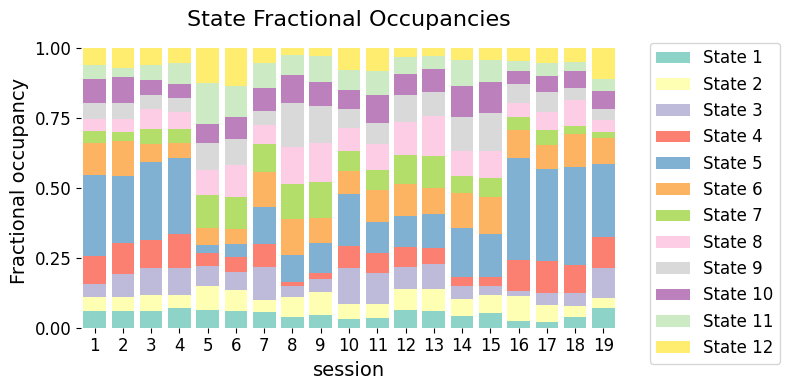

In [18]:
# Calculate the fractional occupancy
FO = utils.get_FO(Gamma_tde, indices_tde)

# Plot FO for each session
graphics.plot_FO(FO, 
                 num_x_ticks=len(idx_data), 
                 xlabel="session", 
                 save_path=PATH_FIGURES / "4_FO_vpath.pdf")

del Gamma_tde,FO

The plot shows the time spent in each state for all sessions. While the overall distribution appears consistent across sessions, some variability between sessions is evident [(Ahrends et al., 2022)](https://www.sciencedirect.com/science/article/pii/S1053811922001550). 

## Part 2 & 3 - Statistical Analysis and visualisation <a id="stat_analysis"></a>

### Step 6. Types of test - Across-state-visits test <a id="stat_test"></a>
With the Viterbi path (`vpath_data`) representing brain states ($D$) and the pupillometry data (`R_data`) representing physiological measurements ($R$), we can now study their relationship using the function `test_across_state_visits`. This analysis focuses on exploring how brain state transitions align with fluctuations in pupil size. This helps us to answer, for instance, whether there are brain states linked to larger or smaller pupil sizes.


#### Using precomputed Viterbi Path surrogates
Running the statistical test directly can take some time due because we need to generate many surrogate permutations. To save time, we have prepared a precomputed surrogate dataset of the Viterbi path with 1000 permutations. This dataset can be loaded and input directly into the function, bypassing the need to compute the surrogates during the analysis. Here’s how you can generate and save the surrogate dataset by yourself: 

```python
# Generate the Viterbi path surrogates
vpath_surrogates = statistics.surrogate_state_time_matrix(
                    Nperm=1000,  # Number of permutations
                    vpath_data=D_vpath,  # Viterbi path
                    n_states=D_vpath_pad.shape[-1] # 12 states in this case
)
# Save the Viterbi path surrogates as a NumPy file
np.save(PATH_DATA / 'vpath_surrogates.npy', vpath_surrogates)

```

In [19]:
# Load precomputed Viterbi path surrogates
vpath_surrogates = np.load(PATH_DATA / 'vpath_surrogate_1000.npy')

# Display the shape of the surrogates
print(f"Shape of vpath_surrogates: {vpath_surrogates.shape}")

Shape of vpath_surrogates: (1473460, 1000)


The surrogate dataset has a shape of `(1473460, 1000)`, which represents:
* Timepoints (1473460): Total number of timepoints across all sessions.
* Permutations (1000): Number of surrogate permutations.


#### Visualise Viterbi Path surrogates
We can visualise the Viterbi path for the first 1,000 timepoints, focusing on both the unpermuted path (`perm = 0`) and the first permuted path (`perm = 1`). This comparison highlights how surrogate Viterbi paths are generated.

The surrogate paths are randomised, meaning the identity of the states is shuffled for each visit. However, the statistical properties related to when the state transition occur, and what is their relative frequency, are preserved. 

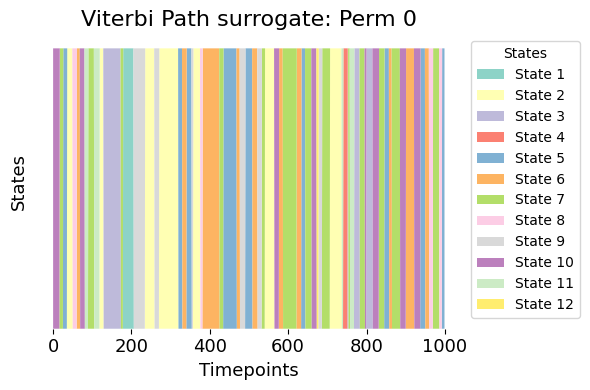

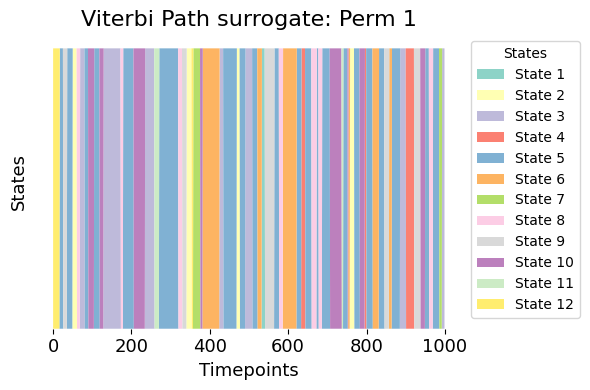

In [20]:
# Loop through permutations to visualise Viterbi path
for perm in [0, 1]:
    # Convert the Viterbi path surrogate to state time courses
    stc = statistics.viterbi_path_to_stc(vpath_surrogates[:1000, perm], 12)
    # Plot the state time courses
    graphics.plot_vpath(stc, figsize=(6, 4), ylabel="States", title=f"Viterbi Path surrogate: Perm {perm}")

### Step 7. Multivariate Test <a id="multi_test"></a>

The multivariate analysis evaluates whether the decoded brain states ($D$, represented by `D_vpath`) contribute to explaining the observed variability in physiological measurements ($R$, represented by `R_data`). This approach considers all brain states simultaneously, and tries to answer whether patterns in brain states correspond to changes in pupil size during rest. A significant result would indicate that the overall sequence of brain states (`D_vpath`) is linked to pupil size (`R_data`).

---

##### Inputs and Settings

To perform the multivariate analysis using the `test_across_state_visits` function, the following inputs and settings are defined:

**Inputs:**
* ```D_data```: The Viterbi path of the brain data (```D_vpath```).
* ```R_data```: The behavioural measurements that is the pupil size (```R_data```).

**Settings:**
* ```method = "multivariate"```: Which test should perform multivariate analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
* ```vpath_surrogates=vpath_surrogates``` : Precomputed Viterbi path surrogates
---

##### Run the ```test_across_state_visits``` function
The results will be stored in a dictionary called `results_multivariate`, containing the output for the analysis. 



In [22]:
# Set parameters for univariate testing
method = "multivariate"

# Set the parameters for across-state-visits testing
results_multivariate = statistics.test_across_state_visits(
    D_data=D_vpath,  # Viterbi path
    R_data=R_data,  # Pupil size measurements
    method=method,  # Use multivariate analysis
    vpath_surrogates=vpath_surrogates  # Precomputed Viterbi path surrogates
)

100%|██████████| 1000/1000 [06:05<00:00,  2.73it/s]


We can now examine the ```results_multivariate``` variable, which is a dictionary containing the results of a statistical analysis.


Let us break it down:
* ```pval```: the p-values resulting from the permutation test. Each value corresponds to a concurrent time series and will have shape of 1 by q. Here q is 1, because we have one single pupil time series. 

* ```base_statistics```:  the base statistics of the tests. In this case it is  explained variance $R^2$

* ```test_statistic```:  by default  a list of the base (unpermuted) statistics when ```test_statistic_option=False```. This list can store the test statistics associated with the permutation test. It provides information about the permutation distribution that is used to calculate the p-values. The output will exported if we set ```test_statistic_option=True```

* ```test_type```:  the type of permutation test performed. In this case, it is ```across_visits```

* ```method```:  the  method employed, which is ```'multivariate'```, which means that the analysis is carried out using regression-based permutation testing

* ```test_combination```  whether p-values are combined. This can be done across rows (producing one p-value per row), across columns (producing one p-value per column), or into a single combined p-value for the entire matrix

* ```max_correction```: Boolean value that indicates whether Max correction has been applied when performing permutation testing

* ```performed_tests```: A dictionary that marks the columns in the test_statistics or p-value matrix corresponding to the (q dimension) where t-tests or F-tests have been performed

* ```Nperm```:  the number of permutations that has been performed

In [23]:
# Display summary statistics
statistics.display_test_summary(results_multivariate)


Model Summary:
    Outcome     R²  F-stat  df1     df2  p-value (R²)
Regressor 1 0.0056     0.0   12 1399831         0.001

Coefficients Table:
Predictor     Outcome     T-stat  p-value       LLCI       ULCI
  State 1 Regressor 1  -1.102099 0.990991  -1.152376  -1.107731
  State 2 Regressor 1  13.028876 0.993994  13.091986  13.569864
  State 3 Regressor 1 -14.937512 0.878879 -15.332628 -14.851203
  State 4 Regressor 1 -43.818583 0.980981 -45.303075 -43.859280
  State 5 Regressor 1  47.347373 0.000000  43.854070  44.654826
  State 6 Regressor 1  10.477196 0.761762  10.386529  10.683442
  State 7 Regressor 1   4.512516 0.680681   4.465814   4.594593
  State 8 Regressor 1   9.952546 0.543544   9.830628  10.102049
  State 9 Regressor 1   0.056353 0.773774   0.055838   0.057446
 State 10 Regressor 1 -12.350822 0.905906 -12.653260 -12.293181
 State 11 Regressor 1 -14.563169 0.873874 -14.921392 -14.467919
 State 12 Regressor 1 -40.337793 0.985986 -41.941288 -40.432192


#### Step 8. Multiple Comparison - Multivariate <a id="multi_corr"></a>
To reduce the risk of false positives (type I errors), it’s important to account for multiple comparisons. To handle this, we apply Benjamini/Hochberg correction to the `results_multivariate` output, which adjusts p-values to control for false discovery rates. This uses the `pval_correction` function, which offers various correction methods based on `statsmodels`' multitest module.

In [24]:
# Apply Benjamini/Hochberg correction to multivariate p-values
results_multivariate["pval_fdr_bh"], _ = statistics.pval_correction(
    results_multivariate, method='fdr_bh'
)

#### Step 9. P-value plots - Multivariate  <a id="multi_vis"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_values_bar` function. For the multivariate test, the p-values are stored as an array with the shape `[1, q]`, where $q$=1 (size of the pupil size).

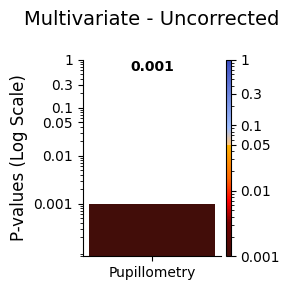

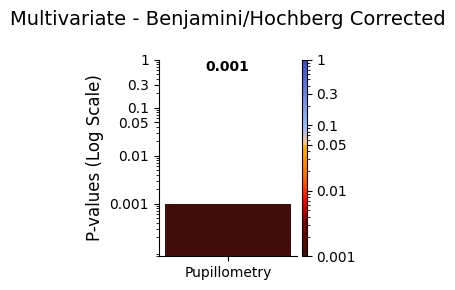

In [25]:
# Plot uncorrected p-values
graphics.plot_p_values_bar(results_multivariate["pval"], 
                           title_text ="Multivariate - Uncorrected", 
                           figsize=(3,3),
                           xticklabels=["Pupillometry"],
                           xlabel_rotation=0,
                           save_path=PATH_FIGURES / "4_multi_uncorrected.pdf")

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_values_bar(results_multivariate["pval_fdr_bh"], 
                           title_text ="Multivariate - Benjamini/Hochberg Corrected", 
                           figsize=(3,3), 
                           xticklabels=["Pupillometry"],
                           xlabel_rotation=0,
                           save_path=PATH_FIGURES / "4_multi_fdr_bh.pdf")
                      

### Step 7. Univariate Test <a id="uni_test"></a>
The univariate test examines the relationship between individual brain states ($D$, represented by `D_vpath`) and physiological measurements ($R$, represented by `R_data`). Unlike the multivariate test, which analyses all brain states together, the univariate approach looks at each brain state separately. 

---

##### Inputs and Settings

To perform the univariate analysis using the `test_across_state_visits` function, the following inputs and settings are defined:

**Inputs:**
* ```D_data```: The state time courses of the brain data (```D_vpath```).
* ```R_data```: The behavioural measurements that is the pupil size (```R_data```).

**Settings:**
* ```method = "univariate"```: Specifies that the test should perform univaraite analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
* ```vpath_surrogates=vpath_surrogates``` : Precomputed Viterbi path surrogates
---

##### Run the ```test_across_state_visits``` function
We will store the results in a dictionary called `results_univariate`, which will hold the output for each brain state.



In [26]:
# Set parameters for univariate testing
method = "univariate"

# Set the parameters for across-state-visits testing
results_univariate = statistics.test_across_state_visits(
    D_data=D_vpath,  # Brain state time courses
    R_data=R_data,  # Pupil size measurements
    method=method,  # Use multivariate analysis
    vpath_surrogates=vpath_surrogates  # Precomputed Viterbi path surrogates
)

100%|██████████| 1000/1000 [02:44<00:00,  6.09it/s]


The output structure of `result_univariate` is the same as for the multivariate test and will not be repeated here.

#### Step 8. Multiple Comparison - Univariate <a id="uni_corr"></a>
To correct for multiple comparisons, we apply Benjamini/Hochberg Correction: This method adjusts p-values to control for false discovery rates. This uses the `pval_correction` function, which offers various correction methods based on `statsmodels`' multitest module.

In [27]:
# Apply Benjamini/Hochberg correction to multivariate p-values
results_univariate["pval_fdr_bh"], _ = statistics.pval_correction(
    results_univariate, method='fdr_bh'
)

#### Step 9. P-value plots - Univariate <a id="uni_corr2"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_values_bar` function.For the univariate test, the p-values are stored as an array with the shape `[p, q]`, where $p$=12 (representing 12 states) and $q$=1 (one timeseries of the pupil size).

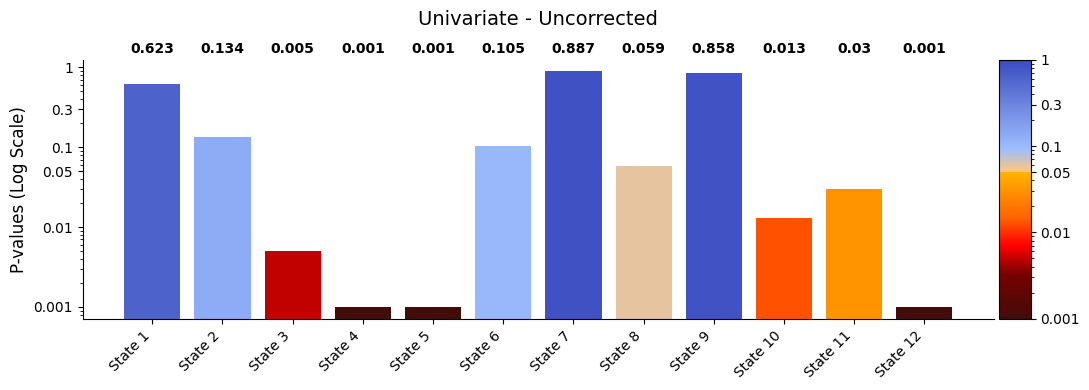

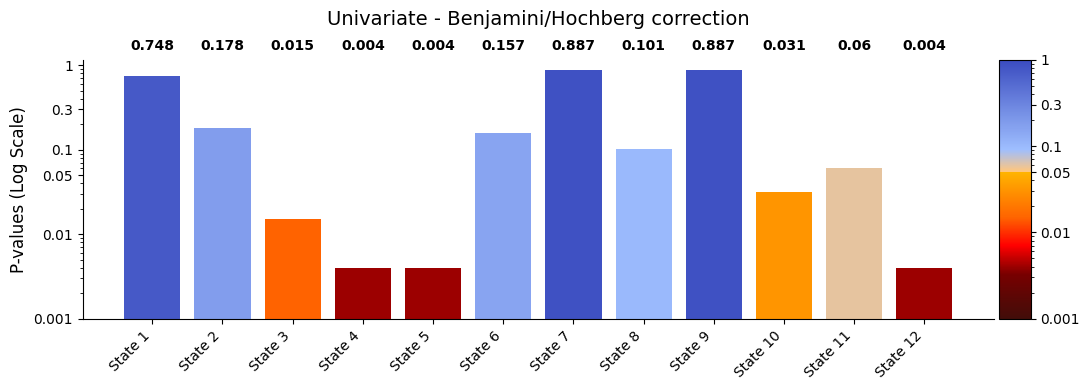

In [32]:
# Create x-tick labels
xticklabels = [f"State {i+1}"for i in range(len(results_univariate["pval"])) ]
# Plot uncorrected p-values
graphics.plot_p_values_bar(results_univariate["pval"], 
                           title_text ="Univariate - Uncorrected", 
                           figsize=(11, 4), 
                           xlabel_rotation=45, 
                           xticklabels=xticklabels, 
                           pval_text_height_same=True, 
                           save_path=PATH_FIGURES / "4_uni_uncorrected.pdf")

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_values_bar(results_univariate["pval_fdr_bh"], 
                           title_text ="Univariate - Benjamini/Hochberg correction", 
                           figsize=(11, 4), 
                           xlabel_rotation=45, 
                           xticklabels=xticklabels, 
                           pval_text_height_same=True,
                           save_path=PATH_FIGURES / "4_uni_fdr_bh.pdf")


### Step 7. One-state-vs-the-rest (OSR) test <a id="rest_test"></a>
The OSR permutation test evaluates whether a specific brain state ($D$, represented by `D_vpath`) differs significantly from the combined influence of all other brain states in relation to a physiological measurement ($R$, represented by `R_data`). Unlike the univariate test, which examines the relationship between each brain state and the measured signal, this approach specifically contrasts one state against the rest.

---

##### Inputs and Settings

To perform the OSR analysis using the `test_across_state_visits` function, the following inputs and settings are defined:

**Inputs:**
* ```D_data```: The state time courses of the brain data (```D_vpath```).
* ```R_data```: The behavioural measurements that is the pupil size (```R_data```).

**Settings:**
* ```method = "OSR"```: Specifies that the test should perform OSR analysis.
* ```Nperm```: Number of permutations (optional, default is 1000).
* ```vpath_surrogates=vpath_surrogates``` : Precomputed Viterbi path surrogates
---

##### Run the ```test_across_state_visits``` function
We will store the results in a dictionary called `results_OSR`, which will hold the output for each brain state.



In [29]:
# Set parameters for OSR testing
method = "OSR"

# Set the parameters for across-state-visits testing
results_OSR = statistics.test_across_state_visits(
    D_data=D_vpath,  # Brain state time courses
    R_data=R_data,  # Pupil size measurements
    method=method,  # Use multivariate analysis
    vpath_surrogates=vpath_surrogates  # Precomputed Viterbi path surrogates
)

100%|██████████| 1000/1000 [01:44<00:00,  9.56it/s]


The output structure of `results_OSR` is the same as for the multivariate test and will not be repeated here.

#### Step 8. Multiple Comparison - OSR test <a id="one_rest_corr"></a>

As before, we can apply the Benjamini/Hochberg method using the `pval_correction` function.


In [30]:
# Apply Benjamini/Hochberg correction to multivariate p-values
results_OSR["pval_fdr_bh"], _ = statistics.pval_correction(
    results_OSR, method='fdr_bh'
)

#### Step 9. P-value plots - OSR test  <a id="one_rest_vis"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_values_bar` function. For the OSR test, the p-values are stored as an array with the shape `[p, q]`, where $p$=12 (representing 12 states) and $q$=1 (size of the pupil size).

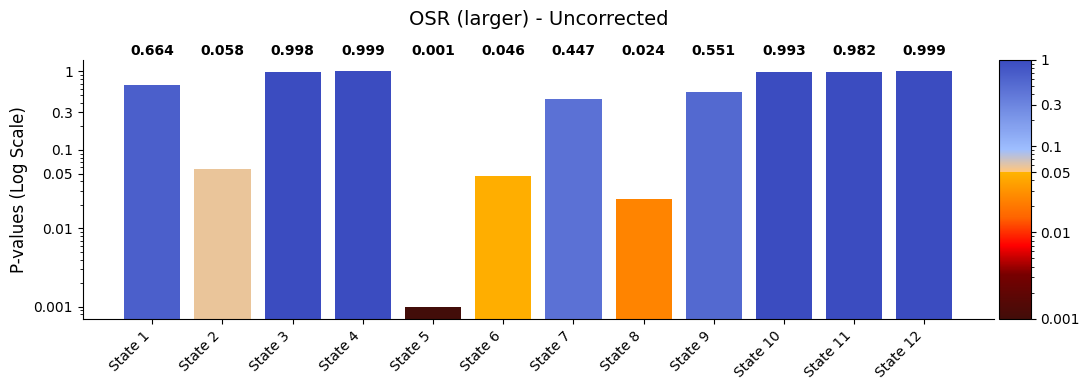

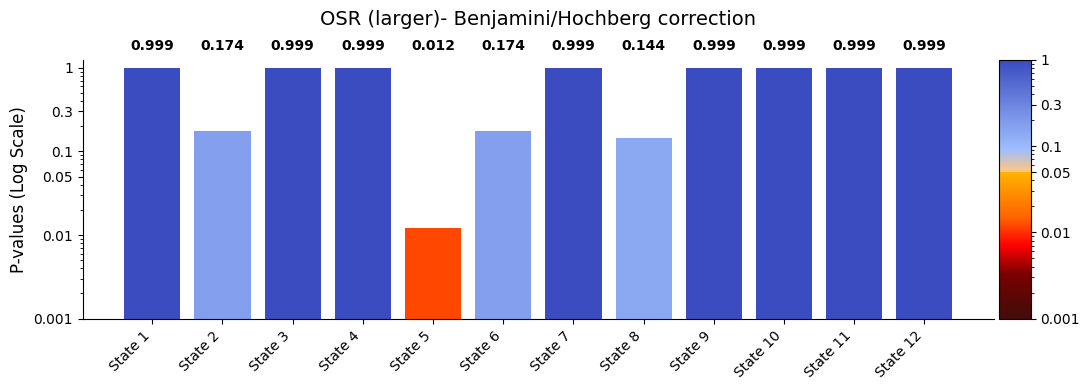

In [31]:
# Plot uncorrected p-values
graphics.plot_p_values_bar(results_OSR["pval"], 
                           title_text ="OSR (larger) - Uncorrected", 
                           figsize=(11, 4), 
                           xlabel_rotation=45, 
                           xticklabels=xticklabels, 
                           pval_text_height_same=True,
                           save_path=PATH_FIGURES / "4_OSR_larger_uncorrected.pdf")

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_values_bar(results_OSR["pval_fdr_bh"], 
                           title_text ="OSR (larger)- Benjamini/Hochberg correction", 
                           figsize=(11, 4), 
                           xlabel_rotation=45, 
                           xticklabels=xticklabels, 
                           pval_text_height_same=True,
                           save_path=PATH_FIGURES / "4_OSR_larger_fdr_bh.pdf")


### Step 7. One-state-vs-another-state (OSA) Test <a id="pair_test"></a>
The OSA test evaluates differences in pupillometry between pairs of brain states. For example, it compares the mean pupil size during State 1 vs. State 2, State 1 vs. State 3, and so on. This analysis helps us understand how physiological signals, such as pupil size, vary between specific brain states.

---

##### Inputs and Settings

To perform the univariate analysis using the `test_across_state_visits` function, the following inputs and settings are defined:

**Inputs:**
* ```D_data```: The state time courses of the brain data (```D_vpath```).
* ```R_data```: The behavioural measurements that is the pupil size (```R_data```).

**Settings:**
* ```method = "OSA"```: Specifies that the test should perform OSA analysis.
* ```Nperm```: Number of permutations (optional, default is 1000)..
* ```vpath_surrogates=vpath_surrogates``` : Precomputed Viterbi path surrogates
---

##### Run the ```test_across_state_visits``` function
We will store the results in a dictionary called `results_OSA `, which will hold the output for each brain state.



In [33]:
# Set parameters for the state pair comparison test
method = "OSA"

# Run the analysis
results_OSA = statistics.test_across_state_visits(
    D_data=D_vpath,
    R_data=R_data,
    method=method,
    vpath_surrogates=vpath_surrogates
)

Pairwise comparisons: 100%|██████████| 66/66 [11:02<00:00, 10.04s/it]


The output structure of `results_OSA` is the same as for the multivariate test and will not be repeated here.

#### Step 8. Multiple Comparison - OSA <a id="pair_corr"></a>

This is done as before:

In [34]:
# Apply Benjamini/Hochberg correction to multivariate p-values
results_OSA["pval_fdr_bh"], _ = statistics.pval_correction(
    results_OSA, method='fdr_bh'
)

#### P-value plots - OSA  <a id="pair_vis"></a>
With both uncorrected and corrected p-values calculated, we can now visualise them using the `plot_p_value_matrix` function. For OSA, the p-values are stored as an array with the shape `[p, p]`, where $p$=12 (representing 12 states).

**Values above the diagonal compare State X > State Y. Values below the diagonal compare State X < State Y.**

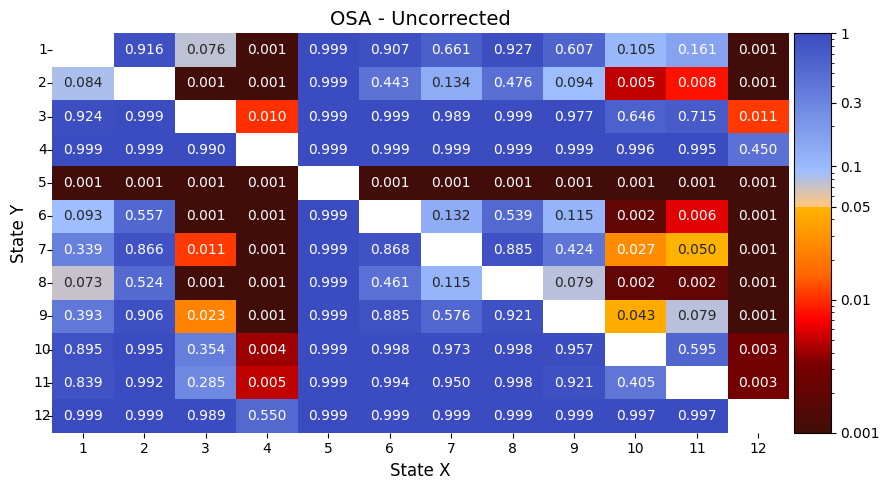

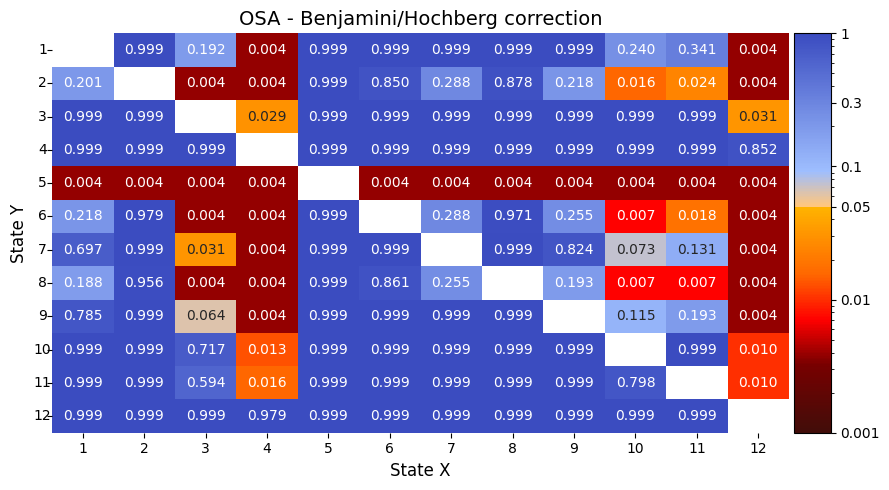

In [35]:
# Plot uncorrected p-values
graphics.plot_p_value_matrix(results_OSA["pval"], 
                             title_text ="OSA - Uncorrected",
                             figsize=(9, 5), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True, 
                             x_tick_min=1, 
                             x_tick_max=len(results_OSA["pval"]),
                             save_path=PATH_FIGURES / "4_OSA_uncorrected.pdf")

# Plot Benjamini/Hochberg corrected p-values
graphics.plot_p_value_matrix(results_OSA["pval_fdr_bh"], 
                             title_text ="OSA - Benjamini/Hochberg correction",
                             figsize=(9, 5), 
                             xlabel="State X", 
                             ylabel="State Y", 
                             alpha=0.05, 
                             none_diagonal=True, 
                             annot=True, 
                             x_tick_min=1, 
                             x_tick_max=len(results_OSA["pval_fdr_bh"]),
                             save_path=PATH_FIGURES / "4_OSA_fdr_bh.pdf")